# SAHI with TorchVision for Sliced Inference

## 0. Preparation

- Install latest version of SAHI and Torchvision:

In [ ]:
!pip install -U git+https://github.com/obss/sahi
!pip install torch torchvision

In [ ]:
import os
os.getcwd()

- Import required modules:

In [7]:
# import required functions, classes
from sahi import AutoDetectionModel
from sahi.predict import get_sliced_prediction, predict, get_prediction
from sahi.utils.file import download_from_url
from sahi.utils.cv import read_image
from IPython.display import Image

In [8]:
# set torchvision FasterRCNN model
import torchvision
from torchvision.models.detection import FasterRCNN_ResNet50_FPN_Weights

model = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT)

# download test images into demo_data folder
download_from_url('https://raw.githubusercontent.com/obss/sahi/main/demo/demo_data/small-vehicles1.jpeg', 'demo_data/small-vehicles1.jpeg')
download_from_url('https://raw.githubusercontent.com/obss/sahi/main/demo/demo_data/terrain2.png', 'demo_data/terrain2.png')

## 1. Standard Inference with a Torchvision Model

- Instantiate a torchvision model by defining model weight path, config path and other parameters:

In [9]:
detection_model = AutoDetectionModel.from_pretrained(
    model_type='torchvision',
    model=model,
    confidence_threshold=0.5,
    image_size=640,
    device="cpu", # or "cuda:0"
    load_at_init=True,
)


- Perform prediction by feeding the `get_prediction` function with an image path and a DetectionModel instance:

In [10]:
result = get_prediction("demo_data/small-vehicles1.jpeg", detection_model)

- Or perform prediction by feeding the `get_prediction` function with a numpy image and a DetectionModel instance:

In [5]:
result = get_prediction(read_image("demo_data/small-vehicles1.jpeg"), detection_model)

- Visualize predicted bounding boxes and masks over the original image:

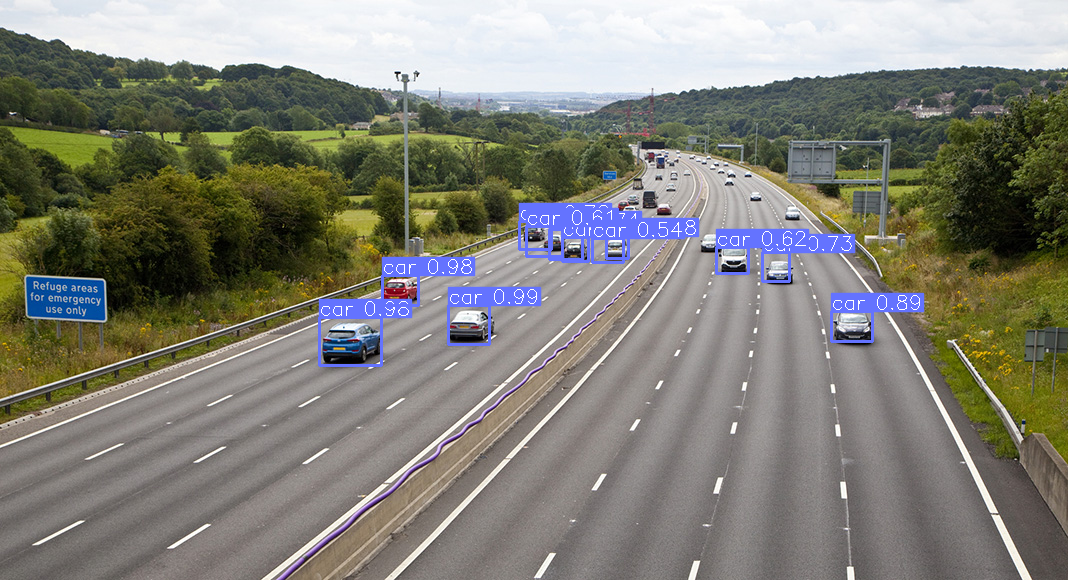

In [11]:
result.export_visuals(export_dir="demo_data/")

Image("demo_data/prediction_visual.png")

## 2. Sliced Inference with a TorchVision Model

- To perform sliced prediction we need to specify slice parameters. In this example we will perform prediction over slices of 320x320 with an overlap ratio of 0.2:

In [7]:
result = get_sliced_prediction(
    "demo_data/small-vehicles1.jpeg",
    detection_model,
    slice_height = 320,
    slice_width = 320,
    overlap_height_ratio = 0.2,
    overlap_width_ratio = 0.2,
)

Performing prediction on 12 slices.


- Visualize predicted bounding boxes and masks over the original image:

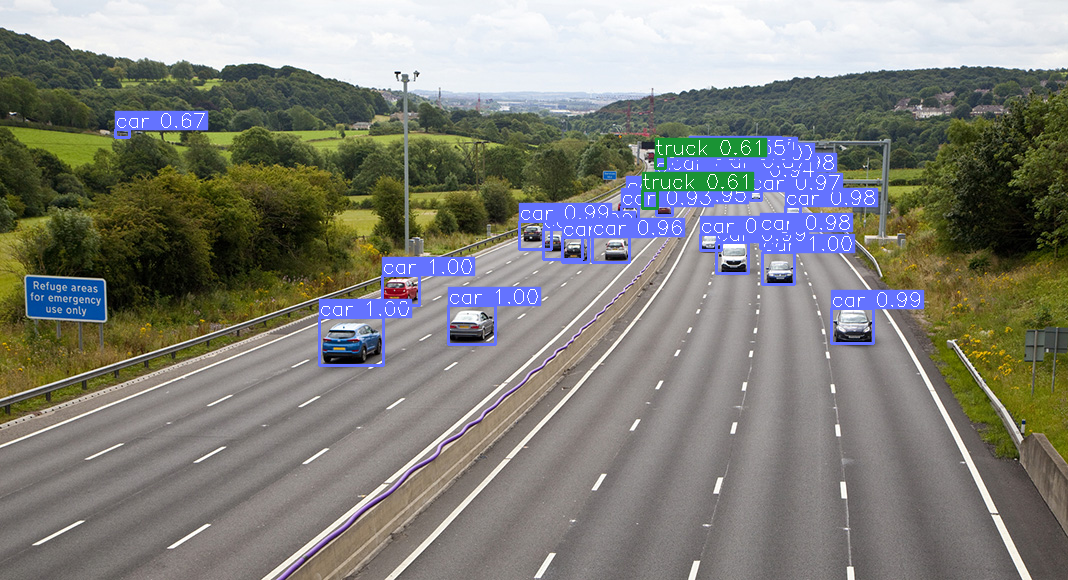

In [8]:
result.export_visuals(export_dir="demo_data/")

Image("demo_data/prediction_visual.png")

## 3. Prediction Result

- Predictions are returned as [sahi.prediction.PredictionResult](sahi/prediction.py), you can access the object prediction list as:

In [9]:
object_prediction_list = result.object_prediction_list

In [10]:
object_prediction_list[0]

ObjectPrediction<
    bbox: BoundingBox: <(np.float64(319.9983215332031), np.float64(317.1016845703125), np.float64(383.74927520751953), np.float64(365.41888427734375)), w: 63.750953674316406, h: 48.31719970703125>,
    mask: None,
    score: PredictionScore: <value: 0.9990587830543518>,
    category: Category: <id: 3, name: car>>

- ObjectPrediction's can be converted to [COCO annotation](https://cocodataset.org/#format-data) format:

In [11]:
result.to_coco_annotations()[:3]

[{'image_id': None,
  'bbox': [319.9983215332031,
   317.1016845703125,
   63.750953674316406,
   48.31719970703125],
  'score': 0.9990587830543518,
  'category_id': 3,
  'category_name': 'car',
  'segmentation': [],
  'iscrowd': 0,
  'area': 3080},
 {'image_id': None,
  'bbox': [448.3526611328125,
   305.8587646484375,
   47.124786376953125,
   38.234619140625],
  'score': 0.9988723397254944,
  'category_id': 3,
  'category_name': 'car',
  'segmentation': [],
  'iscrowd': 0,
  'area': 1801},
 {'image_id': None,
  'bbox': [762.3434448242188,
   252.02978515625,
   31.857330322265625,
   32.469417572021484],
  'score': 0.996906578540802,
  'category_id': 3,
  'category_name': 'car',
  'segmentation': [],
  'iscrowd': 0,
  'area': 1034}]

- ObjectPrediction's can be converted to [COCO prediction](https://github.com/i008/COCO-dataset-explorer) format:

In [12]:
result.to_coco_predictions(image_id=1)[:3]

[{'image_id': 1,
  'bbox': [319.9983215332031,
   317.1016845703125,
   63.750953674316406,
   48.31719970703125],
  'score': 0.9990587830543518,
  'category_id': 3,
  'category_name': 'car',
  'segmentation': [],
  'iscrowd': 0,
  'area': 3080},
 {'image_id': 1,
  'bbox': [448.3526611328125,
   305.8587646484375,
   47.124786376953125,
   38.234619140625],
  'score': 0.9988723397254944,
  'category_id': 3,
  'category_name': 'car',
  'segmentation': [],
  'iscrowd': 0,
  'area': 1801},
 {'image_id': 1,
  'bbox': [762.3434448242188,
   252.02978515625,
   31.857330322265625,
   32.469417572021484],
  'score': 0.996906578540802,
  'category_id': 3,
  'category_name': 'car',
  'segmentation': [],
  'iscrowd': 0,
  'area': 1034}]

- ObjectPrediction's can be converted to [imantics](https://github.com/jsbroks/imantics) annotation format:

In [ ]:
!pip install -U imantics

In [13]:
result.to_imantics_annotations()[:3]

## 4. Batch Prediction

- Set model and directory parameters:

In [15]:
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
detection_model = AutoDetectionModel.from_pretrained(
    model_type='torchvision',
    model=model,
    confidence_threshold=0.4,
    image_size=640,
    device="cpu", # or "cuda:0"
    load_at_init=True,
)

slice_height = 256
slice_width = 256
overlap_height_ratio = 0.2
overlap_width_ratio = 0.2

source_image_dir = "demo_data/"

- Perform sliced inference on given folder:

In [16]:
predict(
    detection_model=detection_model,
    source=source_image_dir,
    slice_height=slice_height,
    slice_width=slice_width,
    overlap_height_ratio=overlap_height_ratio,
    overlap_width_ratio=overlap_width_ratio,
)

There are 3 listed files in folder: demo_data/


Performing inference on images:   0%|          | 0/3 [00:00<?, ?it/s]

Performing prediction on 15 slices.


Performing inference on images:  33%|███▎      | 1/3 [00:04<00:08,  4.30s/it]

Prediction time is: 4271.57 ms
Performing prediction on 15 slices.


Performing inference on images:  67%|██████▋   | 2/3 [00:08<00:04,  4.38s/it]

Prediction time is: 4413.79 ms
Performing prediction on 20 slices.


Performing inference on images: 100%|██████████| 3/3 [00:14<00:00,  4.89s/it]

Prediction time is: 5902.43 ms
Prediction results are successfully exported to runs/predict/exp6


## 5. Sliced Segmentation

SAHI also supports the torchvision maskrcnn and maskrcnn_v2 instance segmentation models:

In [19]:
maskrcnn_model = torchvision.models.detection.maskrcnn_resnet50_fpn(weights=torchvision.models.detection.MaskRCNN_ResNet50_FPN_Weights.DEFAULT)
detection_model_seg = AutoDetectionModel.from_pretrained(
    model_type='torchvision',
    model=maskrcnn_model,
    confidence_threshold=0.5,
    mask_threshold=0.8,
    image_size=1333,
    device="cpu", # or "cuda:0"
    load_at_init=True,
)
im = read_image("demo_data/small-vehicles1.jpeg")

- Perform standard segmentation:

In [20]:
result = get_prediction(im, detection_model_seg)

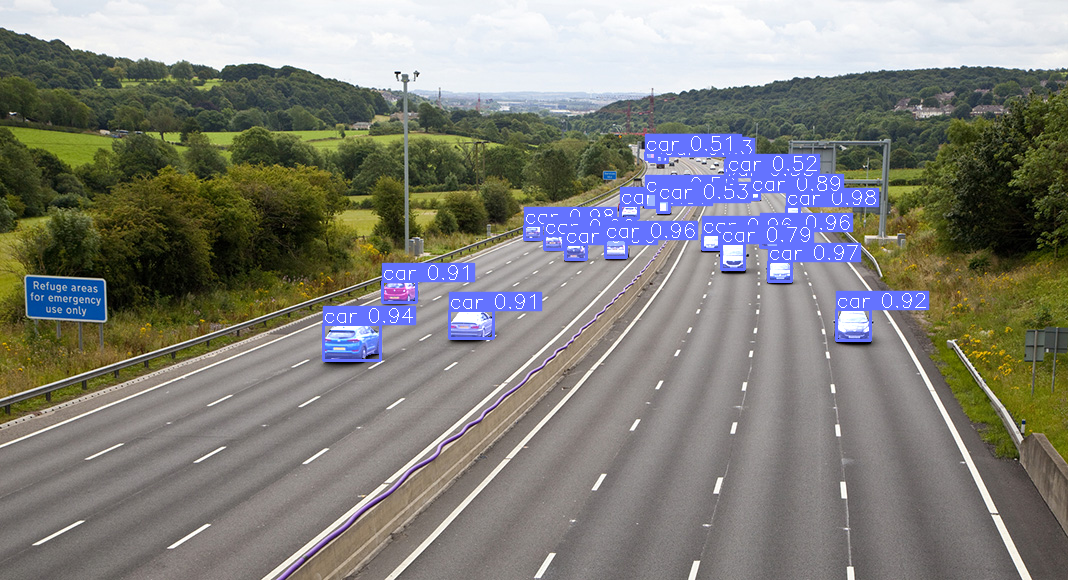

In [21]:
result.export_visuals(export_dir="demo_data/")

Image("demo_data/prediction_visual.png")

- Repeat for sliced segmentation:

In [22]:
result = get_sliced_prediction(
    im,
    detection_model_seg,
    slice_height = 320,
    slice_width = 320,
    overlap_height_ratio = 0.2,
    overlap_width_ratio = 0.2,
)

Performing prediction on 12 slices.


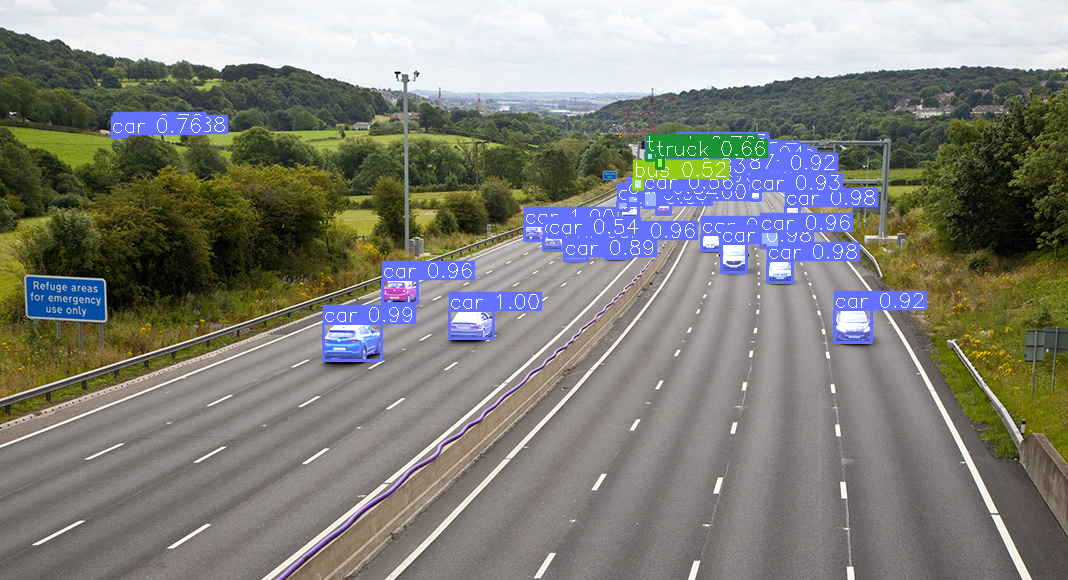

In [23]:
result.export_visuals(export_dir="demo_data/")

Image("demo_data/prediction_visual.png")

Sliced predictions are much better!

- Observe the prediction format:

In [24]:
object_prediction_list = result.object_prediction_list
object_prediction_list[0]

ObjectPrediction<
    bbox: BoundingBox: <(524, 225, 544, 240), w: 20, h: 15>,
    mask: <sahi.annotation.Mask object at 0x7ad2a3b7dbd0>,
    score: PredictionScore: <value: 0.9975883960723877>,
    category: Category: <id: 3, name: car>>

In [25]:
object_prediction_list[0].mask.segmentation

[[526,
  227,
  526,
  228,
  525,
  229,
  524,
  230,
  524,
  234,
  524,
  236,
  524,
  240,
  525,
  240,
  526,
  239,
  528,
  239,
  537,
  239,
  538,
  239,
  539,
  239,
  540,
  240,
  541,
  240,
  542,
  239,
  543,
  239,
  544,
  238,
  544,
  237,
  544,
  233,
  543,
  232,
  543,
  231,
  541,
  229,
  541,
  228,
  540,
  227,
  539,
  226,
  538,
  226,
  537,
  225,
  536,
  225,
  535,
  226,
  534,
  226,
  533,
  225,
  532,
  225,
  531,
  226,
  529,
  226,
  528,
  226,
  527,
  227]]